<a href="https://colab.research.google.com/github/qubvel/transformers-notebooks/blob/main/notebooks/DAB_DETR_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference with DAB-DETR

In this notebook, we'll perform inference with the [DAB-DETR](https://huggingface.co/docs/transformers/main/model_doc/dab-detr) object-detection model.

Abstract:  

*We present in this paper a novel query formulation using dynamic anchor boxes for DETR (DEtection TRansformer) and offer a deeper understanding of the role of queries in DETR. This new formulation directly uses box coordinates as queries in Transformer decoders and dynamically updates them layer-by-layer. Using box coordinates not only helps using explicit positional priors to improve the query-to-feature similarity and eliminate the slow training convergence issue in DETR, but also allows us to modulate the positional attention map using the box width and height information. Such a design makes it clear that queries in DETR can be implemented as performing soft ROI pooling layer-by-layer in a cascade manner. As a result, it leads to the best performance on MS-COCO benchmark among the DETR-like detection models under the same setting, e.g., AP 45.7\% using ResNet50-DC5 as backbone trained in 50 epochs.*

![](https://github.com/IDEA-Research/DAB-DETR/blob/main/figure/arch_new2.png?raw=true)

 - Paper: https://arxiv.org/abs/2201.12329

## Set-up environment

Let's start by upgrading 🤗 Transformers as the model is brand new at the time of writing.

In [ ]:
!pip install --upgrade git+https://github.com/huggingface/transformers

## Load model and image processor

We'll load an DAB-DETR checkpoint from the [hub](https://huggingface.co/IDEA-Research). Note that the authors have released 6 different checkpoints which leverage various settings. Here we load one that leverages a [ResNet-50](https://huggingface.co/docs/transformers/en/model_doc/resnet) backbone which has been trained on COCO dataset.

In [2]:
import torch
from transformers import AutoImageProcessor, AutoModelForObjectDetection

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

checkpoint = "IDEA-Research/dab-detr-resnet-50"

# Alternative checkpoints:
# checkpoint = "IDEA-Research/dab-detr-resnet-50-dc5-fixxy"
# checkpoint = "IDEA-Research/dab-detr-resnet-50-dc5-pat3"
# checkpoint = "IDEA-Research/dab-detr-resnet-50-dc5"
# checkpoint = "IDEA-Research/dab-detr-resnet-50-pat3"

image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = AutoModelForObjectDetection.from_pretrained(checkpoint).to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/4.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/175M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

## Load image

Next we'll load our image on which we'll perform inference.

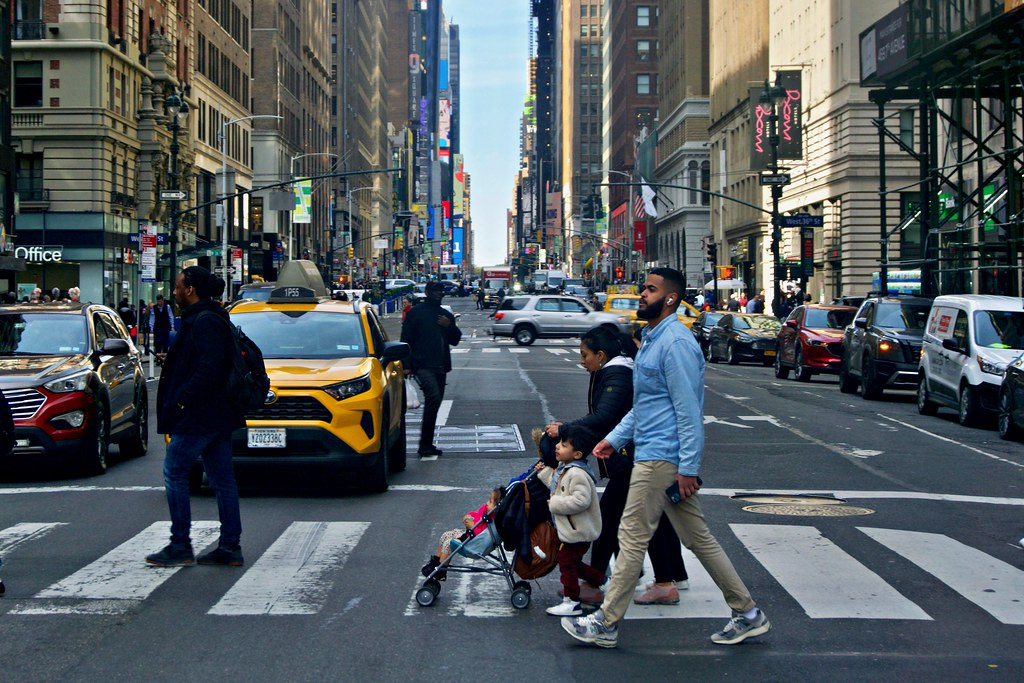

In [3]:
from PIL import Image
import requests

url = "https://live.staticflickr.com/65535/33021460783_1646d43c54_b.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

## Forward pass

The API is exactly the same as other object detection models in the Transformers library, which means that we first prepare the image for the model using the image processor, after which we forward the pixel values through the model in order to obtain class logits and predicted bounding boxes.

In [4]:
inputs = image_processor(image, return_tensors="pt")
inputs = inputs.to(device)

print(inputs.keys())

dict_keys(['pixel_values', 'pixel_mask'])


In [5]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

## Postprocess & visualize

Let's visualize the results! For that we first need to call the `post_process_object_detection` method on the image processor which turns the bounding box coordinates as predicted by the model in the Pascal VOC format, which is (xmin, ymin, xmax, ymax), adjusted for the size of the original image.

We also specify a threshold in order to only keep bounding box predictions for which the class prediction has a confidence of at least 0.3.

In [6]:
# postprocess model outputs
postprocessed_outputs = image_processor.post_process_object_detection(
    outputs,
    target_sizes=[(image.height, image.width)],
    threshold=0.3,
)
image_detections = postprocessed_outputs[0]  # take only first image results

Next we can visualize the results on the image using libraries like Matplotlib or OpenCV.

In [7]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [
    [0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933],
] * 100

def plot_results(pil_image, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_image)
    ax = plt.gca()
    for score, label, box, color in zip(scores, labels, boxes, COLORS):
        xmin, ymin, xmax, ymax = box
        ax.add_patch(
          plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False,
            color=color,
            linewidth=1,
          )
        )
        text = f"{model.config.id2label[label]}: {score:0.2f}"
        ax.text(
            xmin, ymin, text, fontsize=8,
            bbox=dict(facecolor='yellow', alpha=0.25),
        )
    plt.axis('off')
    plt.show()

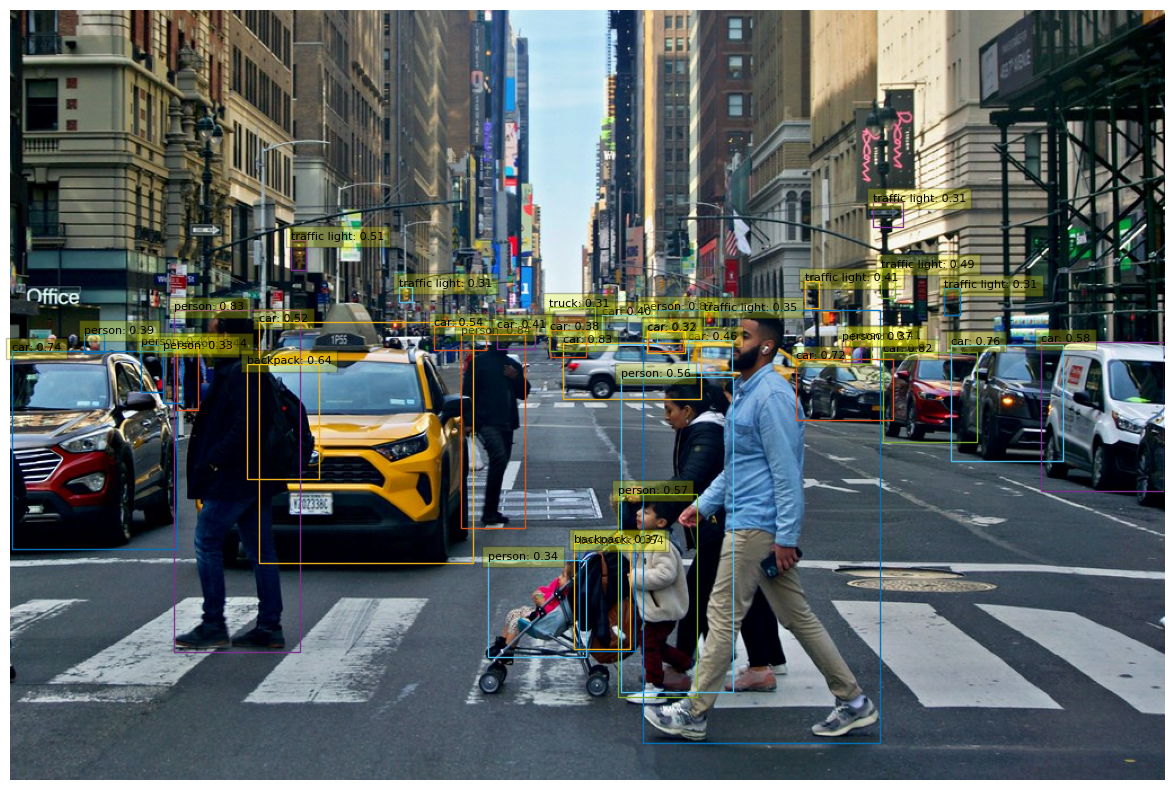

In [8]:
plot_results(
    pil_image=image,
    scores=image_detections['scores'].tolist(),
    labels=image_detections['labels'].tolist(),
    boxes=image_detections['boxes'].tolist(),
)

## Pipeline API

Alternatively, if you don't want to implement the pre- and postprocessing yourself, the Transformers library offers the [pipeline abstraction](https://huggingface.co/docs/transformers/en/main_classes/pipelines) which does all of what we did above for you. Usage is really easy:

In [9]:
from transformers import pipeline

pipe = pipeline("object-detection", model=checkpoint, image_processor=checkpoint)

Device set to use cuda:0


In [10]:
results = pipe(url, threshold=0.3)

In [11]:
results

[{'score': 0.8700045347213745,
  'label': 'person',
  'box': {'xmin': 560, 'ymin': 265, 'xmax': 771, 'ymax': 649}},
 {'score': 0.8395988345146179,
  'label': 'person',
  'box': {'xmin': 399, 'ymin': 286, 'xmax': 456, 'ymax': 459}},
 {'score': 0.832281768321991,
  'label': 'car',
  'box': {'xmin': 490, 'ymin': 295, 'xmax': 612, 'ymax': 344}},
 {'score': 0.8269950151443481,
  'label': 'person',
  'box': {'xmin': 145, 'ymin': 265, 'xmax': 256, 'ymax': 569}},
 {'score': 0.8165582418441772,
  'label': 'car',
  'box': {'xmin': 773, 'ymin': 303, 'xmax': 857, 'ymax': 382}},
 {'score': 0.7610259652137756,
  'label': 'car',
  'box': {'xmin': 834, 'ymin': 296, 'xmax': 933, 'ymax': 399}},
 {'score': 0.73874831199646,
  'label': 'car',
  'box': {'xmin': 1, 'ymin': 302, 'xmax': 147, 'ymax': 477}},
 {'score': 0.7203069925308228,
  'label': 'car',
  'box': {'xmin': 696, 'ymin': 309, 'xmax': 782, 'ymax': 363}},
 {'score': 0.64128577709198,
  'label': 'backpack',
  'box': {'xmin': 209, 'ymin': 313, 'xma

We can visualize the results in a similar way:

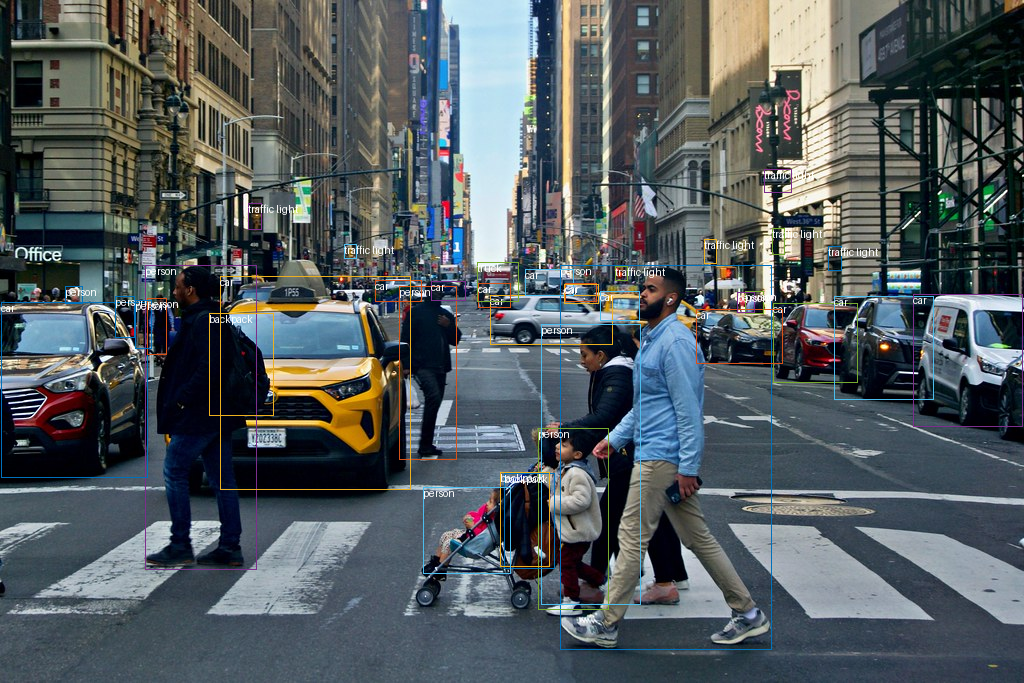

In [12]:
from PIL import ImageDraw

# visualize
# let's use Pillow's ImageDraw feature

annotated_image = image.copy()
draw = ImageDraw.Draw(annotated_image)

for i, result in enumerate(results):
  box = result["box"]
  color = tuple([int(x * 255) for x in COLORS[i]])
  xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
  draw.rectangle((xmin, ymin, xmax, ymax), fill=None, outline=color, width=1)
  draw.text((xmin, ymin, xmax, ymax), text=result["label"])

annotated_image

#### Visualize results from other checkpoints

In [ ]:
checkpoints = [
  "IDEA-Research/dab-detr-resnet-50-dc5",
  "IDEA-Research/dab-detr-resnet-50-pat3",
  "IDEA-Research/dab-detr-resnet-50-dc5-fixxy",
  "IDEA-Research/dab-detr-resnet-50-dc5-pat3",
]

for checkpoint in checkpoints:
  print(checkpoint)
  pipe = pipeline("object-detection", model=checkpoint, image_processor=checkpoint, device=device)
  results = pipe(image, threshold=0.3)

  annotated_image = image.copy()
  draw = ImageDraw.Draw(annotated_image)

  for i, result in enumerate(results):
    box = result["box"]
    color = tuple([int(x * 255) for x in COLORS[i]])
    xmin, ymin, xmax, ymax = box["xmin"], box["ymin"], box["xmax"], box["ymax"]
    draw.rectangle((xmin, ymin, xmax, ymax), fill=None, outline=color, width=1)
    draw.text((xmin, ymin, xmax, ymax), text=result["label"])

  display(annotated_image.resize([640, 480]))